Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.

 Checking and installing required packages...
✓ pandas is already installed
✓ nltk is already installed
✓ sklearn is already installed
✓ seaborn is already installed
✓ xgboost is already installed
✓ torch is already installed

 Please RESTART YOUR KERNEL after installation

 Fake News Detection System

 Loading dataset from: C:/Users/Abdelrahman Ahmed/Downloads/fake_real_news.csv
• Total records: 44,898

Training traditional ML models...

Training Logistic Regression...

 Evaluating Logistic Regression

 Accuracy: 0.9954

 Classification Report:
              precision    recall  f1-score   support

           0     0.9926    0.9979    0.9952      4283
           1     0.9981    0.9932    0.9956      4694

    accuracy                         0.9954      8977
   macro avg     0.9953    0.9955    0.9954      8977
weighted avg     0.9954    0.99

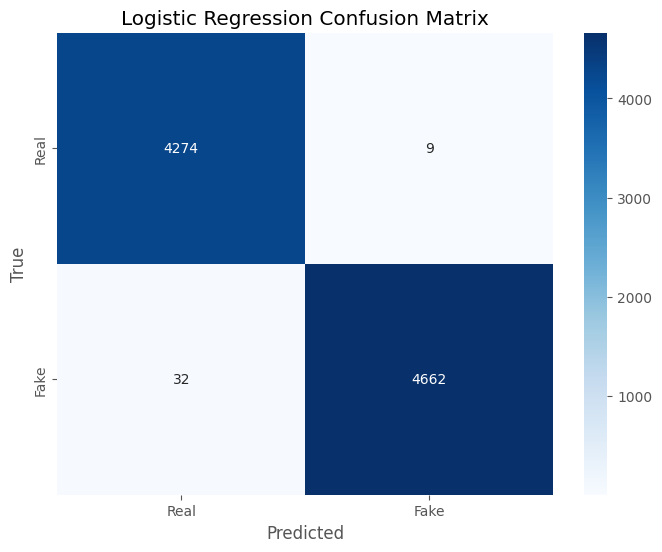


Training Random Forest...

 Evaluating Random Forest

 Accuracy: 0.9940

 Classification Report:
              precision    recall  f1-score   support

           0     0.9909    0.9965    0.9937      4283
           1     0.9968    0.9917    0.9942      4694

    accuracy                         0.9940      8977
   macro avg     0.9939    0.9941    0.9940      8977
weighted avg     0.9940    0.9940    0.9940      8977



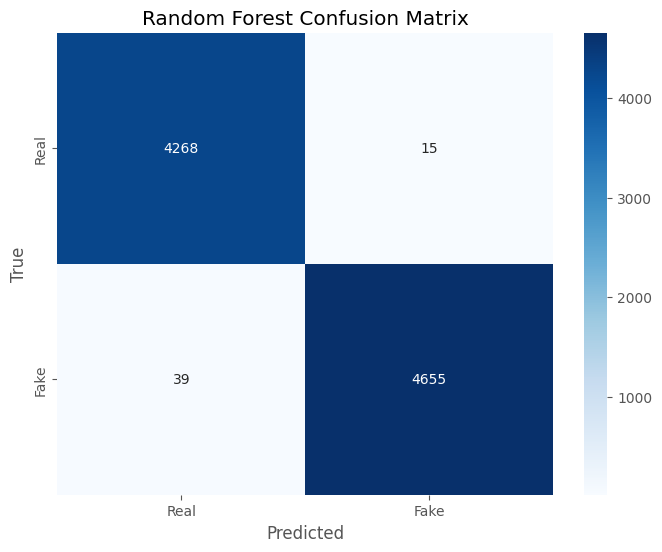


Training Linear SVM...

 Evaluating Linear SVM

 Accuracy: 0.9981

 Classification Report:
              precision    recall  f1-score   support

           0     0.9974    0.9986    0.9980      4283
           1     0.9987    0.9977    0.9982      4694

    accuracy                         0.9981      8977
   macro avg     0.9981    0.9981    0.9981      8977
weighted avg     0.9981    0.9981    0.9981      8977



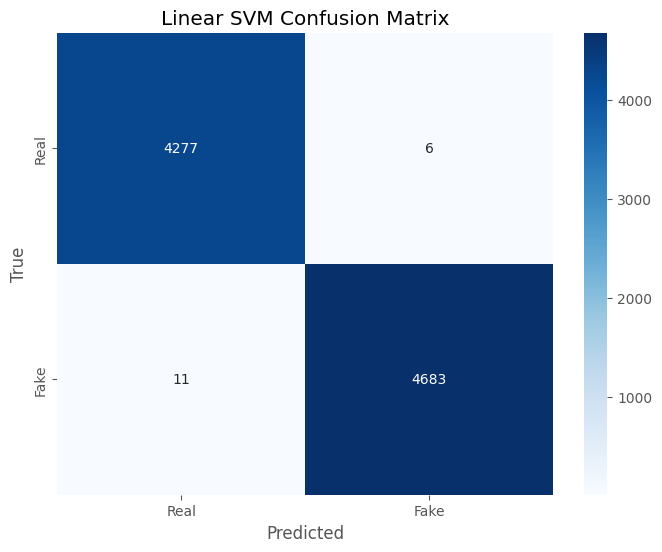


----------------------------------------
 Training LSTM Model
----------------------------------------
Epoch: 01
	Train Loss: 0.656 | Train Acc: 60.58%
	Test Loss: 0.661 | Test Acc: 57.13%
Epoch: 02
	Train Loss: 0.616 | Train Acc: 66.84%
	Test Loss: 0.550 | Test Acc: 75.13%
Epoch: 03
	Train Loss: 0.484 | Train Acc: 75.59%
	Test Loss: 0.059 | Test Acc: 98.87%
Epoch: 04
	Train Loss: 0.048 | Train Acc: 98.83%
	Test Loss: 0.010 | Test Acc: 99.82%
Epoch: 05
	Train Loss: 0.019 | Train Acc: 99.59%
	Test Loss: 0.013 | Test Acc: 99.77%

Final Evaluation:
Accuracy: 0.9977

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9963    0.9988    0.9976      4283
         1.0     0.9989    0.9966    0.9978      4694

    accuracy                         0.9977      8977
   macro avg     0.9976    0.9977    0.9977      8977
weighted avg     0.9977    0.9977    0.9977      8977



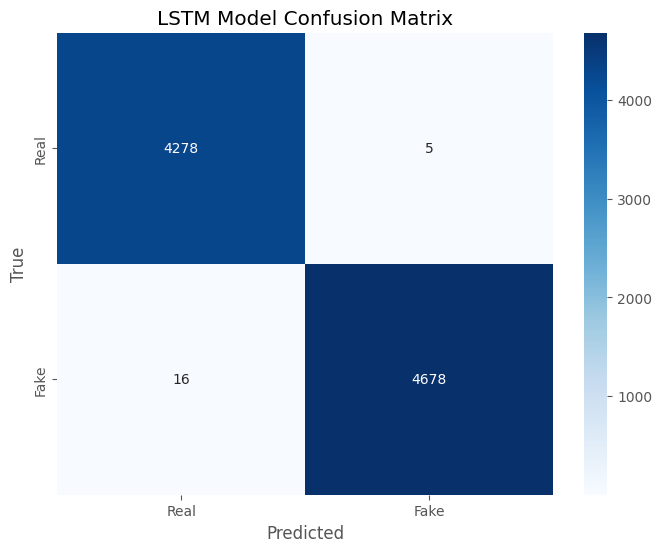

In [2]:
%pip install torch
# Import all required libraries
import os
import sys
import subprocess
import pandas as pd
import re
import string
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('ggplot')

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def install_packages():
    required_packages = [
        ('pandas', 'pandas'),
        ('nltk', 'nltk'),
        ('sklearn', 'scikit-learn'),
        ('seaborn', 'seaborn'),
        ('xgboost', 'xgboost'),
        ('torch', 'torch')
    ]
    print("\n Checking and installing required packages...")
    for import_name, package_name in required_packages:
        try:
            __import__(import_name)
            print(f"✓ {import_name} is already installed")
        except ImportError:
            print(f" Installing {package_name}...")
            try:
                subprocess.run([sys.executable, "-m", "pip", "install", package_name], check=True)
                print(f"✓ {package_name} installed successfully")
            except subprocess.CalledProcessError:
                print(f" Failed to install {package_name}")
    print("\n Please RESTART YOUR KERNEL after installation")

def load_data(filepath):
    try:
        print(f"\n Loading dataset from: {filepath}")
        df = pd.read_csv(filepath)
        df['text'] = df['text'].astype(str)
        print(f"• Total records: {len(df):,}")
        return df
    except FileNotFoundError:
        print(f"\n Error: File not found at {filepath}")
        exit()

def preprocess_text(text, stop_words, lemmatizer):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    words = [w for w in text.split() if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n{'='*50}\n Evaluating {model_name}\n{'='*50}")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Accuracy: {acc:.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# LSTM Model for text classification
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

def train_lstm(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        text = batch['text'].to(device)
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, batch['label'].to(device))
        acc = binary_accuracy(predictions, batch['label'].to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_lstm(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            text = batch['text'].to(device)
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, batch['label'].to(device))
            acc = binary_accuracy(predictions, batch['label'].to(device))
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(rounded_preds.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), all_preds, all_labels

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        numericalized_text = [self.vocab[word] if word in self.vocab else 0 for word in text.split()]
        length = len(numericalized_text)
        
        # Pad or truncate
        if length < self.max_length:
            numericalized_text = numericalized_text + [0] * (self.max_length - length)
        else:
            numericalized_text = numericalized_text[:self.max_length]
            length = self.max_length
            
        return {
            'text': torch.tensor(numericalized_text, dtype=torch.long), 
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

def main():
    print("\n" + "="*50)
    print(" Fake News Detection System")
    print("="*50)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filepath = 'C:/Users/Abdelrahman Ahmed/Downloads/fake_real_news.csv'
    df = load_data(filepath)

    label_cols = ['label', 'is_fake', 'fake', 'target']
    label_column = next((col for col in label_cols if col in df.columns), None)
    if not label_column:
        print("Enter label column name: ")
        label_column = input()
    df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
    df['label'] = df[label_column].map({0: 0, 1: 1, 'fake': 1, 'real': 0})  # Ensure binary labels
    df['cleaned_content'] = df['content'].apply(lambda x: preprocess_text(x, stop_words, lemmatizer))
    df = df[df['cleaned_content'].str.split().str.len() > 5]

    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_content'], 
        df['label'], 
        test_size=0.2, 
        random_state=42,
        stratify=df['label']
    )

    # One-hot encoding for traditional ML models
    vectorizer = CountVectorizer(
        binary=True,
        max_features=5000,
        min_df=5,
        max_df=0.8,
        stop_words='english'
    )
    X_train_onehot = vectorizer.fit_transform(X_train)
    X_test_onehot = vectorizer.transform(X_test)

    # Machine Learning Models
    print("\nTraining traditional ML models...")
    
    # 1. Logistic Regression with L1 regularization
    print("\nTraining Logistic Regression...")
    lr = LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000
    )
    lr.fit(X_train_onehot, y_train)
    evaluate_model(lr, X_test_onehot, y_test, "Logistic Regression")

    # 2. Random Forest with adjusted parameters
    print("\nTraining Random Forest...")
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train_onehot, y_train)
    evaluate_model(rf, X_test_onehot, y_test, "Random Forest")

    # 3. Linear SVM (good for high-dimensional sparse data)
    print("\nTraining Linear SVM...")
    svm = LinearSVC(
        C=0.1,
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
    svm.fit(X_train_onehot, y_train)
    evaluate_model(svm, X_test_onehot, y_test, "Linear SVM")

    # Deep Learning with LSTM
    print("\n" + "-"*40)
    print(" Training LSTM Model")
    print("-"*40)
    
    # Build vocabulary from training data
    words = [word for text in X_train for word in text.split()]
    word_counts = Counter(words)
    vocab = {word: idx+1 for idx, (word, count) in enumerate(word_counts.most_common(5000))}  # Top 5000 words
    vocab_size = len(vocab) + 1  # +1 for padding
    
    # Parameters
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 1
    N_LAYERS = 2
    DROPOUT = 0.5
    BATCH_SIZE = 64
    MAX_LENGTH = 200  # Max sequence length
    
    # Create datasets
    train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), vocab, MAX_LENGTH)
    test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), vocab, MAX_LENGTH)
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTMModel(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCEWithLogitsLoss()
    
    # Training loop
    N_EPOCHS = 5
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_lstm(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc, _, _ = evaluate_lstm(model, test_loader, criterion, device)
        
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    
    # Final evaluation
    _, _, y_pred, y_true = evaluate_lstm(model, test_loader, criterion, device)
    print("\nFinal Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('LSTM Model Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

if __name__ == "__main__":
    if 'google.colab' not in sys.modules:
        install_packages()
    main()